In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson

    Observation:
        Type: Box(4)
        Num	Observation               Min             Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                -24 deg         24 deg
        3	Pole Velocity At Tip      -Inf            Inf

    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right

        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is 

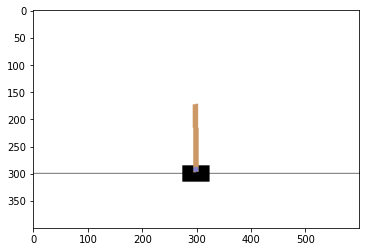

In [2]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
print(env.__doc__)

# Creating NN agent

In [14]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential

In [15]:
class ApproximateExpectedSarsa:
    def __init__(self, state_dim, n_actions, epsilon=0.9, gamma=0.9,
                eta=1e-4):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.eta = eta
        self.model, self.sess = self.make_model()
        self.initiate_placeholders()
        self.train_step = self.make_graph()
        self.sess.run(tf.global_variables_initializer())
        
    def make_model(self):
        tf.reset_default_graph()
        sess = tf.InteractiveSession()
        tf.keras.backend.set_session(sess)
        model = Sequential([L.InputLayer(state_dim),
                   L.Dense(200,activation='relu'),
                   L.Dense(100, activation='relu'),
                   L.Dense(self.n_actions)])
        return model, sess
    
    def initiate_placeholders(self):
        self.states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.actions_ph = tf.keras.backend.placeholder(dtype='int32', shape=[None])
        self.rewards_ph = tf.keras.backend.placeholder(dtype='float32', shape=[None])
        self.next_states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.is_done_ph = tf.keras.backend.placeholder(dtype='bool', shape=[None])
    
    def argmax(self,q_table):
        max_value = np.max(q_table)
        idxs = np.where(q_table==max_value)[0]
        if idxs.shape[0]>1:
            return np.random.choice(idxs)
        else:
            return np.argmax(q_table)
        
    def get_action(self, state):
        q_values = self.model.predict(state[None])[0]
    
        if np.random.rand()<self.epsilon:
              action = np.random.choice(n_actions)
        else:
              action = self.argmax(q_values)

        return action
    
    def make_graph(self):
        predicted_qvalues = self.model(self.states_ph)
        predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(self.actions_ph, self.n_actions), 
                                                      axis=1)
        predicted_next_qvalues = self.model(self.next_states_ph)
        next_state_values = 1/self.n_actions * tf.reduce_sum(predicted_next_qvalues,axis=1)
        target_qvalues_for_actions = self.rewards_ph+self.gamma*next_state_values
        target_qvalues_for_actions = tf.where(self.is_done_ph, self.rewards_ph, target_qvalues_for_actions)
        loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
        loss = tf.reduce_mean(loss)
        return tf.train.AdamOptimizer(self.eta).minimize(loss)
    
    def update(self,s,a,r,next_s,done):
        self.sess.run(self.train_step,{
                self.states_ph: [s], self.actions_ph: [a], self.rewards_ph: [r], 
                self.next_states_ph: [next_s], self.is_done_ph: [done]
            })
        
        

In [26]:
epsilon=0.2
gamma=0.99
eta=1e-4

In [27]:
agent = ApproximateExpectedSarsa(state_dim,n_actions,
                            epsilon=epsilon, gamma=gamma, eta=eta)

# Training an agent

In [28]:
def generate_session(agent, env, train=False, t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(s)       
        next_s, r, done, _ = env.step(a)
        if train:
            agent.update(s,a,r,next_s,done)
        total_reward += r
        s = next_s
        if done:
            break
            
    return total_reward

In [29]:
def train(agent, env, epochs=1000,episodes=100,
         epsilon_decay=True):
    for i in range(epochs):
        session_rewards = [generate_session(agent, env, train = True) for _ in range(episodes)]
        print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
        if epsilon_decay:
            agent.epsilon *= 0.99
        assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

        if np.mean(session_rewards) > 300:
            print("You Win!")
            break

In [30]:
train(agent,env,epsilon_decay=False)

epoch #0	mean reward = 10.390	epsilon = 0.200
epoch #1	mean reward = 10.300	epsilon = 0.200
epoch #2	mean reward = 10.660	epsilon = 0.200
epoch #3	mean reward = 10.970	epsilon = 0.200
epoch #4	mean reward = 11.620	epsilon = 0.200
epoch #5	mean reward = 13.780	epsilon = 0.200
epoch #6	mean reward = 10.270	epsilon = 0.200
epoch #7	mean reward = 11.100	epsilon = 0.200
epoch #8	mean reward = 10.530	epsilon = 0.200
epoch #9	mean reward = 15.810	epsilon = 0.200
epoch #10	mean reward = 16.820	epsilon = 0.200
epoch #11	mean reward = 26.560	epsilon = 0.200
epoch #12	mean reward = 46.420	epsilon = 0.200
epoch #13	mean reward = 76.240	epsilon = 0.200
epoch #14	mean reward = 70.610	epsilon = 0.200
epoch #15	mean reward = 133.810	epsilon = 0.200
epoch #16	mean reward = 236.880	epsilon = 0.200
epoch #17	mean reward = 219.760	epsilon = 0.200
epoch #18	mean reward = 140.110	epsilon = 0.200
epoch #19	mean reward = 150.830	epsilon = 0.200
epoch #20	mean reward = 180.160	epsilon = 0.200
epoch #21	mean re

# Showing agent performance

In [34]:
from IPython.core import display

In [35]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Sum of rewards : 50.0


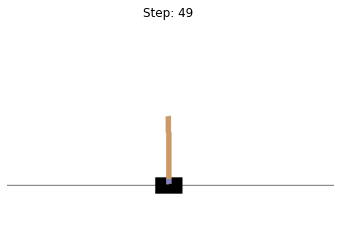

In [36]:
env = gym.make('CartPole-v0')
steps = 50
s = env.reset()
rewards = 0
for t in range(steps):
    show_state(env,t)
    env.render()
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
    rewards+=r
    s = next_s
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
display.clear_output(wait=True)
print("Sum of rewards : {}".format(rewards))